In [78]:
# import libraries
import pandas as pd
import folium
# ignore warning
import warnings
warnings.filterwarnings("ignore")

jan = pd.read_csv("../preprocessed_data/January.csv")
feb = pd.read_csv("../preprocessed_data/February.csv")
mar = pd.read_csv("../preprocessed_data/March.csv")
jan_2020 = pd.read_csv("../preprocessed_data/January_2020.csv")
feb_2020 = pd.read_csv("../preprocessed_data/February_2020.csv")
mar_2020 = pd.read_csv("../preprocessed_data/March_2020.csv")

In [79]:
import geopandas as gpd

# sf stands for shape file
# code is taken from https://github.com/akiratwang/MAST30034_Python Lab2_Python
sf = gpd.read_file("../taxi_data/taxi_zones.shp")
zone = pd.read_csv("../taxi_data/taxi+_zone_lookup.csv")
sf['geometry'] = sf['geometry'].to_crs("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")

In [80]:
# concatenate january - march 2019
frames_2019 = [jan, feb, mar]
taxi_2019 = pd.concat(frames_2019)

In [81]:
taxi_2019

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,...,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,"Rain, Melted Snow, Etc. (in)","Snow, Ice, Pellets, Hail (in)","Snow, Ice, Pellets, Hail, Ice on Ground (in)",weather_median,time_traveled (seconds)
0,0,1,2019-01-01 00:46:40,2019-01-01 00:53:20,1,1.50,1,N,151,239,...,1.65,0.0,0.3,9.95,NaN,"0,06",0,0,48.5,400.0
1,1,1,2019-01-01 00:59:47,2019-01-01 01:18:59,1,2.60,1,N,239,246,...,1.00,0.0,0.3,16.30,NaN,"0,06",0,0,48.5,1152.0
2,2,1,2019-01-01 00:21:28,2019-01-01 00:28:37,1,1.30,1,N,163,229,...,1.25,0.0,0.3,9.05,NaN,"0,06",0,0,48.5,429.0
3,3,1,2019-01-01 00:32:01,2019-01-01 00:45:39,1,3.70,1,N,229,7,...,3.70,0.0,0.3,18.50,NaN,"0,06",0,0,48.5,818.0
4,4,1,2019-01-01 00:57:32,2019-01-01 01:09:32,2,2.10,1,N,141,234,...,1.70,0.0,0.3,13.00,NaN,"0,06",0,0,48.5,720.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6750111,7832393,2,2019-03-31 23:19:33,2019-03-31 23:22:55,2,0.75,1,N,48,230,...,1.66,0.0,0.3,9.96,2.5,"0,06",0,0,52.0,202.0
6750112,7832394,2,2019-03-31 23:35:19,2019-03-31 23:39:30,1,1.17,1,N,100,249,...,2.79,0.0,0.3,12.09,2.5,"0,06",0,0,52.0,251.0
6750113,7832396,2,2019-03-31 23:20:15,2019-03-31 23:24:12,1,1.11,1,N,263,236,...,0.00,0.0,0.3,9.30,2.5,"0,06",0,0,52.0,237.0
6750114,7832398,2,2019-03-31 22:32:57,2019-03-31 23:21:22,1,0.00,1,N,237,193,...,0.00,0.0,0.0,0.00,2.5,"0,06",0,0,52.0,2905.0


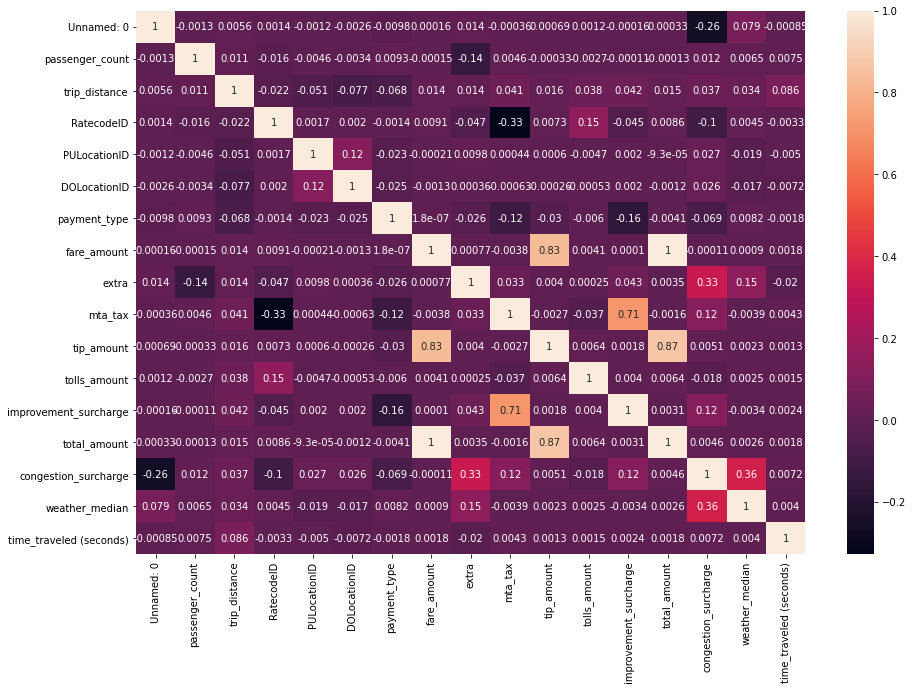

In [54]:
# graph 1: make heat map
heat_map = taxi_2019
heat_map = heat_map.drop(columns = ["VendorID"])
plt.subplots(figsize=(15, 10))
sns.heatmap(heat_map.corr(), annot = True)
plt.savefig("../plots/heat_map.png")

In [76]:
from folium.plugins import HeatMap

# geospatial visualisation clustering on Lab 2 https://github.com/akiratwang/MAST30034_Python
pickups_heatmap = folium.Map(location=[40.66, -73.94], tiles="Stamen Terrain", zoom_start=10)
pickups_heatmap.add_child(HeatMap(jan[COORDS].values, radius=10))

pickups_heatmap.save('../plots/foliumPickupHeatmap.html')
pickups_heatmap

In [82]:
# first, we are going to merge gdf file 
jan_gdf = gpd.GeoDataFrame(pd.merge(jan, sf, left_on = "PULocationID", right_on="LocationID")).drop("LocationID", axis=1)
feb_gdf = gpd.GeoDataFrame(pd.merge(feb, sf, left_on = "PULocationID", right_on="LocationID")).drop("LocationID", axis=1)
mar_gdf = gpd.GeoDataFrame(pd.merge(mar, sf, left_on = "PULocationID", right_on="LocationID")).drop("LocationID", axis=1)
janfeb_gdf = jan_gdf.append(feb_gdf, ignore_index = True)
gdf = janfeb_gdf.append(mar_gdf, ignore_index = True)

# remove column with no names
gdf.drop(gdf.columns[0], axis = 1, inplace = True)

# merge gdf drop off 
gdf_drop_off = gpd.GeoDataFrame(pd.merge(taxi_2019, sf, left_on = "DOLocationID", right_on = "LocationID")).drop("LocationID", axis = 1)

In [101]:
# select manhattan zone
manhattan = gdf.loc[gdf["borough"] == "Manhattan"]
top_5 = (gdf.loc[gdf["borough"] == "Manhattan"].groupby(gdf.loc[gdf["borough"] == "Manhattan"].zone).agg(
        median_amount = ("tip_amount", "mean"), median_distance = ("trip_distance", "mean"))
    .sort_values(by = "median_amount", ascending = False))

# store top 5 zones for tip_amount
top_5 = gpd.GeoDataFrame(pd.merge(top_5, sf, left_on = "zone", right_on = "zone"))
top_5.head(5)

,zone,median_amount,median_distance,OBJECTID,Shape_Leng,Shape_Area,LocationID,borough,geometry
0,Randalls Island,6.978415,3.459235,194,0.081794,0.000273,194,Manhattan,"POLYGON ((-73.91640 40.79768, -73.91545 40.797..."
1,Financial District North,2.273468,2.958586,87,0.036902,0.000067,87,Manhattan,"POLYGON ((-74.00372 40.70693, -74.00361 40.706..."
2,Financial District South,2.245549,3.147158,88,0.035205,0.000057,88,Manhattan,"POLYGON ((-74.00975 40.70478, -74.00945 40.704..."
3,Battery Park City,2.201915,2.652057,13,0.050281,0.000149,13,Manhattan,"POLYGON ((-74.01244 40.71906, -74.01282 40.717..."
4,UN/Turtle Bay South,2.194681,1.710095,233,0.048036,0.000116,233,Manhattan,"MULTIPOLYGON (((-73.96547 40.75194, -73.96532 ..."


In [100]:
# pick up location for geospatial visualisation
m_trip_distance = folium.Map(location=[40.66, -73.94], tiles="Stamen Terrain", zoom_start = 10)

# cloropleth graph from https://livecodestream.dev/post/how-to-plot-your-data-on-maps-using-python-and-folium/
geo = manhattan[["zone", "geometry"]].drop_duplicates("zone").to_json()
choropleth = folium.Choropleth(
    geo_data = geo,
    name = "choropleth",
    data = top_5,
    columns = ["zone", "median_amount"],
    key_on = "properties.zone",
    fill_color = "YlGn",
    fill_opacity = 0.7,
    line_opacity  = 0.2,
    legend_name = "Tips",
).add_to(m_trip_distance)
choropleth.geojson.add_child(folium.features.GeoJsonTooltip(["zone"], labels=True)
).add_to(m_trip_distance)

m_trip_distance.save("../plots/tips_pickuploc.html")